# Exercise 4
Due:  Tue November 19, 8:00am

## Node2Vec
1. Implement custom dataset that samples pq-walks
    - Use the utility function from torch_cluster that actually performs the walks
2. Implement Node2Vec module and training
	- Node2Vec essentially consists of a torch.Embedding module and a loss function
3. Evaluate node classification performance on Cora
4. Evaluate on Link Prediction: Cora, PPI
    - use different ways to combine the node two embeddings for link prediction

Bonus Question: are the predictions stable wrt to the random seeds of the walks?

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch_geometric as pyg
from tqdm import tqdm
from torch.utils.data import IterableDataset, DataLoader, Dataset
from torch_cluster import random_walk
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [3]:
# find device
if torch.cuda.is_available(): # NVIDIA
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): # apple M1/M2
    device = torch.device('mps') 
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [4]:
dataset = pyg.datasets.Planetoid(root='./dataset/cora', name='Cora')
cora = dataset[0]
dataset = pyg.datasets.PPI(root='./dataset/ppi')
ppi = dataset[0]

## node2vec embedding training
Here the main training and everything on the graph level is happening.

It might be a good idea to create a dataset of walks (fixed for the whole training process) first to get the whole training process running before attempting to create a train_loader that on-demand samples those walks on-demand.

In [ ]:
from torch.utils.data import IterableDataset

class Node2VecDataset(IterableDataset):
    def __init__(self, graph, p=1.0, q=1.0, walk_length=10, num_walks=10):
        # Step 1: Map node IDs to consecutive integers
        self.num_nodes = graph.num_nodes
        self.edge_index = graph.edge_index        
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.p = p
        self.q = q

    def __iter__(self):
        row, col = self.edge_index
        nodes = torch.unique(row)
        # Shuffle nodes manually
        nodes = nodes[torch.randperm(len(nodes))]
        for _ in range(self.num_walks):
            for start_node in nodes:
                yield random_walk(row, col, torch.tensor([start_node]), walk_length=self.walk_length, p=self.p, q=self.q)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Node2Vec(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(Node2Vec, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_nodes = num_nodes

        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, nodes):
        node_embeds = self.embedding(nodes)
        return node_embeds

In [7]:
def negative_sampling_loss(center_embeddings, context_embeddings, negative_embeddings):
    # Positive score: dot product between center and context embeddings
    pos_score = torch.sum(center_embeddings * context_embeddings, dim=-1)
    pos_loss = F.logsigmoid(pos_score).squeeze()

    # Negative score: dot product between center and negative embeddings
    neg_score = torch.bmm(negative_embeddings, center_embeddings.unsqueeze(2)).squeeze()
    neg_loss = F.logsigmoid(-neg_score).sum(1)

    loss = -(pos_loss + neg_loss).mean()
    return loss


In [ ]:
def train_node2vec(
    model,
    data_loader,
    num_nodes,
    epochs=10,
    window_size=5,
    negative_samples=5,
    lr=0.01,
    device='cpu'
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )
    model.to(device)

    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0
        batch_count = 0
        for walks in data_loader:
            batch_count += 1
            walks = walks.to(device).squeeze(1)
            batch_size, walk_length = walks.shape

            # For each position in the walk
            for pos in range(walk_length):
                center_nodes = walks[:, pos]

                # Determine context window
                start = max(0, pos - window_size)
                end = min(walk_length, pos + window_size + 1)
                context_positions = list(range(start, pos)) + list(range(pos + 1, end))
                if not context_positions:
                    continue  # Skip if context is empty
                context_nodes = walks[:, context_positions]

                # Flatten context nodes
                context_nodes = context_nodes.reshape(-1)

                # Get embeddings
                center_embeddings = model.embedding(center_nodes)
                context_embeddings = model.embedding(context_nodes)

                # Negative sampling
                negative_nodes = torch.randint(
                    0,
                    num_nodes,
                    (batch_size * len(context_positions), negative_samples),
                    device=device
                )
                negative_embeddings = model.embedding(negative_nodes)

                # Compute loss
                loss = negative_sampling_loss(
                    center_embeddings.repeat_interleave(len(context_positions), dim=0),
                    context_embeddings,
                    negative_embeddings
                )

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        avg_loss = total_loss / batch_count
        scheduler.step(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}, No.of samples: {batch_count * data_loader.batch_size}')


In [23]:
# Parameters
embedding_dim = 64
window_size = 5
negative_samples = 5
epochs = 50
lr = 0.01
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
num_nodes = cora.num_nodes
cora_num_classes = cora.y.unique().shape[0]

cora_model = Node2Vec(num_nodes, embedding_dim).to(device)

In [28]:
data_loader = DataLoader(
    Node2VecDataset(cora, p=1.0, q=1.0, walk_length=80,num_walks=10), 
    batch_size=batch_size, 
    # num_workers=os.cpu_count()//2
)

train_node2vec(
    cora_model, 
    data_loader, 
    num_nodes, 
    epochs=epochs, 
    window_size=window_size, 
    negative_samples=negative_samples, 
    lr=lr, 
    device=device
)

/home/ayan/.conda/envs/multicls_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Loss: 310.6971, Learning Rate: 0.010000, No.of samples: 27136
Epoch 2/50, Loss: 301.8162, Learning Rate: 0.010000, No.of samples: 27136
Epoch 3/50, Loss: 301.8018, Learning Rate: 0.010000, No.of samples: 27136
Epoch 4/50, Loss: 301.7563, Learning Rate: 0.010000, No.of samples: 27136
Epoch 5/50, Loss: 301.8012, Learning Rate: 0.010000, No.of samples: 27136
Epoch 6/50, Loss: 301.8466, Learning Rate: 0.010000, No.of samples: 27136
Epoch 7/50, Loss: 301.8120, Learning Rate: 0.010000, No.of samples: 27136
Epoch 8/50, Loss: 301.8722, Learning Rate: 0.001000, No.of samples: 27136
Epoch 9/50, Loss: 297.3069, Learning Rate: 0.001000, No.of samples: 27136
Epoch 10/50, Loss: 295.9129, Learning Rate: 0.001000, No.of samples: 27136
Epoch 11/50, Loss: 295.8106, Learning Rate: 0.001000, No.of samples: 27136
Epoch 12/50, Loss: 295.7892, Learning Rate: 0.001000, No.of samples: 27136
Epoch 13/50, Loss: 295.7953, Learning Rate: 0.001000, No.of samples: 27136
Epoch 14/50, Loss: 295.7804, Learn

In [ ]:
torch.save(cora_model.state_dict(), 'cora_node2vec_model.pth')

## Node classification performance
just a small MLP or even linear layer on the embeddings to predict node classes. Accuracy should be above 60%. Please compare your results to those you achieved with GNNs.

Epoch 10, Train Loss: 1.817e+00, Train Acc: 0.80, Val Loss: 1.888e+00, Val Acc: 0.44
Epoch 20, Train Loss: 1.551e+00, Train Acc: 0.86, Val Loss: 1.745e+00, Val Acc: 0.55
Epoch 30, Train Loss: 1.109e+00, Train Acc: 0.91, Val Loss: 1.518e+00, Val Acc: 0.58
Epoch 40, Train Loss: 6.247e-01, Train Acc: 0.94, Val Loss: 1.266e+00, Val Acc: 0.62
Epoch 50, Train Loss: 2.956e-01, Train Acc: 0.98, Val Loss: 1.129e+00, Val Acc: 0.64
Epoch 60, Train Loss: 1.326e-01, Train Acc: 0.99, Val Loss: 1.181e+00, Val Acc: 0.63
Epoch 70, Train Loss: 6.478e-02, Train Acc: 0.99, Val Loss: 1.286e+00, Val Acc: 0.63
Epoch 80, Train Loss: 3.598e-02, Train Acc: 1.00, Val Loss: 1.381e+00, Val Acc: 0.63
Epoch 90, Train Loss: 2.224e-02, Train Acc: 1.00, Val Loss: 1.464e+00, Val Acc: 0.63
Epoch 100, Train Loss: 1.520e-02, Train Acc: 1.00, Val Loss: 1.527e+00, Val Acc: 0.63
Epoch 110, Train Loss: 1.126e-02, Train Acc: 1.00, Val Loss: 1.577e+00, Val Acc: 0.64
Epoch 120, Train Loss: 8.827e-03, Train Acc: 1.00, Val Loss: 1.

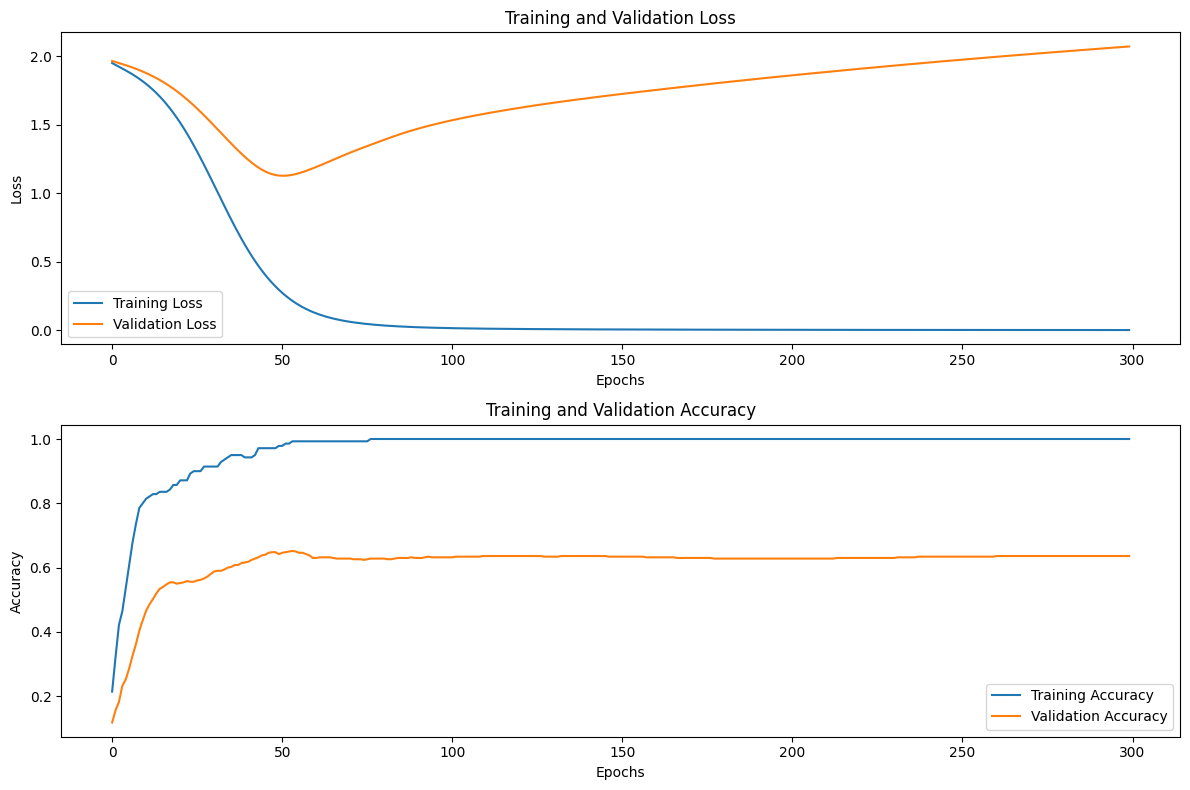

Best Model -> Test Accuracy: 0.65 (Train: 1.00, Val: 0.64)


In [30]:
import matplotlib.pyplot as plt

# as the simple MLP is pretty straightforward
cls_model = torch.nn.Sequential(
    torch.nn.Linear(embedding_dim, 256), # Input layer
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128), # Hidden layer 2
    torch.nn.ReLU(),
    torch.nn.Linear(128, cora_num_classes), # Output layer
)

cls_model = cls_model.to(device)

optimizer = torch.optim.Adam(cls_model.parameters(), lr=0.001)  # define an optimizer
criterion = torch.nn.CrossEntropyLoss()  # define loss function

node2vec_embeddings = cora_model.embedding.weight.to(device)
cora = cora.to(device)


def get_accuracy(cls_model, embeddings, y, mask):
    out = cls_model(embeddings[mask])
    pred = out.argmax(dim=1)
    acc = accuracy_score(y[mask].cpu().numpy(), pred.cpu().detach().numpy())
    return acc

# Initialize storage for losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_model_state = None
best_val_acc = 0.0

for epoch in tqdm(range(300)):  # 300 epochs
    cls_model.train()
    optimizer.zero_grad()
    out = cls_model(node2vec_embeddings[cora.train_mask])  # forward pass
    train_loss = criterion(out, cora.y[cora.train_mask])
    train_loss.backward()
    optimizer.step()

    # Record training loss and accuracy
    train_losses.append(train_loss.item())
    train_acc = get_accuracy(cls_model, node2vec_embeddings, cora.y, cora.train_mask)
    train_accuracies.append(train_acc)

    # Record validation loss and accuracy
    cls_model.eval()
    with torch.no_grad():
        val_out = cls_model(node2vec_embeddings[cora.val_mask])
        val_loss = criterion(val_out, cora.y[cora.val_mask]).item()
        val_losses.append(val_loss)
        val_acc = get_accuracy(cls_model, node2vec_embeddings, cora.y, cora.val_mask)
        val_accuracies.append(val_acc)

        # Save the model if this is the best validation accuracy so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = cls_model.state_dict()

    # Print out loss info periodically
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.3e}, Train Acc: {train_acc:.2f}, "
              f"Val Loss: {val_loss:.3e}, Val Acc: {val_acc:.2f}")
        
# Plot training and validation metrics
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Subplot 2: Accuracy
plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

cls_model.load_state_dict(best_model_state)

# Evaluate accuracy on the best model
train_acc_best = get_accuracy(cls_model, node2vec_embeddings, cora.y, cora.train_mask)
val_acc_best = get_accuracy(cls_model, node2vec_embeddings, cora.y, cora.val_mask)
test_acc_best = get_accuracy(cls_model, node2vec_embeddings, cora.y, cora.test_mask)

print(f"Best Model -> Test Accuracy: {test_acc_best:.2f} (Train: {train_acc_best:.2f}, Val: {val_acc_best:.2f})")


In [32]:
y_true = cora.y[cora.test_mask].cpu().numpy()
y_pred = cls_model(node2vec_embeddings[cora.test_mask]).argmax(dim=1).cpu().numpy()
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.5168    0.5923    0.5520       130
           1     0.5827    0.8132    0.6789        91
           2     0.7597    0.8125    0.7852       144
           3     0.7670    0.4953    0.6019       319
           4     0.5822    0.5705    0.5763       149
           5     0.6748    0.8058    0.7345       103
           6     0.5579    0.8281    0.6667        64

    accuracy                         0.6470      1000
   macro avg     0.6344    0.7025    0.6565      1000
weighted avg     0.6662    0.6470    0.6428      1000



## link prediction on trained embeddings
this should only train simple MLPs.

Note: for link prediction to be worthwhile, one needs to train the embeddings on a subset of the graph (less edges, same nodes) instead of the whole graph.

In [11]:
# for link prediction, do something like the following
link_splitter = pyg.transforms.RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = link_splitter(cora)
# the positive and negative edges are in "edge_label_index" with "edge_label" 
# indicating whether an edge is a true edge or not.

In [ ]:
# retrain node2vec on train_data
link_model = Node2Vec(train_data.num_nodes, embedding_dim=64).to(device)

link_data_loader = DataLoader(
    Node2VecDataset(train_data, p=1.0, q=1.0, walk_length=80,num_walks=10), 
    batch_size=batch_size, 
)

In [13]:
train_node2vec(
    link_model, 
    link_data_loader, 
    train_data.num_nodes, 
    epochs=epochs, 
    window_size=window_size, 
    negative_samples=negative_samples, 
    lr=lr, 
    device=device
)

/home/ayan/.conda/envs/multicls_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Loss: 291.1635, Learning Rate: 0.010000, No.of samples: 25088
Epoch 2/50, Loss: 282.2530, Learning Rate: 0.010000, No.of samples: 25088
Epoch 3/50, Loss: 281.8801, Learning Rate: 0.010000, No.of samples: 25088
Epoch 4/50, Loss: 281.1748, Learning Rate: 0.010000, No.of samples: 25088
Epoch 5/50, Loss: 280.2252, Learning Rate: 0.010000, No.of samples: 25088
Epoch 6/50, Loss: 279.5035, Learning Rate: 0.010000, No.of samples: 25088
Epoch 7/50, Loss: 279.3364, Learning Rate: 0.010000, No.of samples: 25088
Epoch 8/50, Loss: 279.3761, Learning Rate: 0.010000, No.of samples: 25088
Epoch 9/50, Loss: 279.5857, Learning Rate: 0.010000, No.of samples: 25088
Epoch 10/50, Loss: 279.6550, Learning Rate: 0.010000, No.of samples: 25088
Epoch 11/50, Loss: 279.7322, Learning Rate: 0.001000, No.of samples: 25088
Epoch 12/50, Loss: 274.5734, Learning Rate: 0.001000, No.of samples: 25088
Epoch 13/50, Loss: 272.6734, Learning Rate: 0.001000, No.of samples: 25088
Epoch 14/50, Loss: 272.5388, Learn

In [ ]:
# use those (new) embeddings for link prediction

In [19]:
def evaluate_link_prediction(embeddings, edge_label_index, edge_label, method='dot'):
    z = embeddings.detach().numpy()
    src_indices = edge_label_index[0].cpu().numpy()
    dst_indices = edge_label_index[1].cpu().numpy()
    source_emb = z[src_indices]
    target_emb = z[dst_indices]

    if method == 'dot':
        scores = np.sum(source_emb * target_emb, axis=1)
        preds = (scores > 0).astype(int)
        probs = scores  # Use raw scores as probabilities for ROC curve
    elif method == 'hadamard':
        scores = np.prod(source_emb * target_emb, axis=1)
        preds = (scores > 0).astype(int)
        probs = scores
    elif method == 'concat':
        features = np.hstack([source_emb, target_emb])
        clf = LogisticRegression(max_iter=1000)
        clf.fit(features, edge_label.cpu().numpy())
        preds = clf.predict(features)
        probs = clf.predict_proba(features)[:, 1]
    elif method == 'abs_diff':
        features = np.abs(source_emb - target_emb)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(features, edge_label.cpu().numpy())
        preds = clf.predict(features)
        probs = clf.predict_proba(features)[:, 1]
    else:
        raise ValueError("Unknown method for combining embeddings.")

    roc_auc = roc_auc_score(edge_label.cpu().numpy(), probs)
    ap_score = average_precision_score(edge_label.cpu().numpy(), probs)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(edge_label.cpu().numpy(), probs)
    roc_curve_data = (fpr, tpr)

    return roc_auc, ap_score, roc_curve_data

Method: dot, ROC AUC: 0.7165, AP Score: 0.7890
Method: hadamard, ROC AUC: 0.5000, AP Score: 0.5000
Method: concat, ROC AUC: 0.7550, AP Score: 0.7693
Method: abs_diff, ROC AUC: 0.8338, AP Score: 0.8483


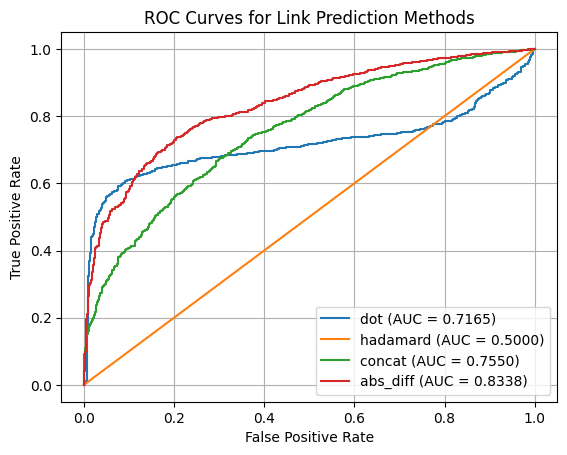

In [22]:
methods = ['dot', 'hadamard', 'concat', 'abs_diff']
embeddings = link_model.embedding.weight.cpu()

plt.figure()
for method in methods:
    roc_auc, ap_score, roc_curve_data = evaluate_link_prediction(
        embeddings,
        test_data.edge_label_index,
        test_data.edge_label,
        method=method
    )
    fpr, tpr = roc_curve_data
    plt.plot(fpr, tpr, label=f'{method} (AUC = {roc_auc:.4f})')
    print(f"Method: {method}, ROC AUC: {roc_auc:.4f}, AP Score: {ap_score:.4f}")
plt.title('ROC Curves for Link Prediction Methods')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('link_prediction_roc_curves.png')  # Save the figure
plt.show()
